In [21]:
from utils import *
from param import *
from skimage import measure
from scipy import ndimage as ndi

### The pipeline to analyse the cells local coexpression using RNAscope technology

It requires:
* QuPath > v0.2.0-m6
* Install the following packages: scikit-image , opencv-python

Optional packages
* SimpleITK for image registration
* stlearn for cell-cell communincation in with Visium data

#### Copy the groovy files from QuPath_pipelines directory the QuPath project folder and run the analysis. 

The detection results of QuPath pipeline are be save under the defined directory from the script. 

We assume that user has already run the QuPath scripts.

The following pipeline is interprete the results from QuPath and generate the interaction heatmap

### Load the images and specify path to result directory of QuPath process into the pipeline 

In [2]:
material_path = '/QRISdata/Q1851/Minh/RNAScope/Tiff_images_all/Tissue_1_E15/'
qupath_output = '/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')

In [3]:
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
img_dapi2 = cv2.cvtColor(cv2.imread(dapi_2), cv2.COLOR_BGR2RGB)
pil_img_dapi1 = Image.fromarray(img_dapi1)
pil_img_dapi2 = Image.fromarray(img_dapi2)
dapi1_gray = pil_img_dapi1.convert('L')
dapi2_gray = pil_img_dapi2.convert('L')
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)
dapi2_gray_itk = get_itk_from_pil(dapi2_gray)
fixed_img = dapi1_gray_itk
moving_img = dapi2_gray_itk

In [4]:
# It's optional to load and run the image registration
# affine_transform = sitk.ReadTransform('BCC_Skin1_r1_registration_affine_transform.tfm')
# bspline_transform = sitk.ReadTransform('BCC_Skin1_r2_registration_bspline_transform.tfm')

# moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
# moving_rgb_final_4 = sitk_transform_rgb(moving_rgb_affine, pil_img_dapi1, bspline_transform)
# print(moving_rgb_final_4.size)
# change_color_mv_rgb_final_4 = np.array(moving_rgb_final_4)
# print(change_color_mv_rgb_final_4.shape)
# converted_color = change_color_mv_rgb_final_4 
# foreground = Image.fromarray(converted_color)
# background = pil_img_dapi1

In [5]:
# 1. Load all the detection result from QuPath into the program
scene1_output_dir = os.path.join(qupath_output, 'Scene_1.2')
list_output_files1 = get_files_in_dir_recursively(scene1_output_dir)
print(len(list_output_files1))
list_output_files1 = np.array(list_output_files1)

6512


In [13]:
all_rects = list()
recorded_parent_boxes = list()
for fn in list_output_files1:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            if len(parent_annots) == 1:
                ratio = medium_window
            else:
                ratio = small_window
#             ratio = small_window
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(ratio*img_dapi1.shape[1]),
                    annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
            all_rects.append(rect)
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi1.shape[1]),
                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
            all_rects.append(rect)



#### Visualize the annotation windows that contain nuclei

1628


(-0.5, 7858.5, 17988.5, -0.5)

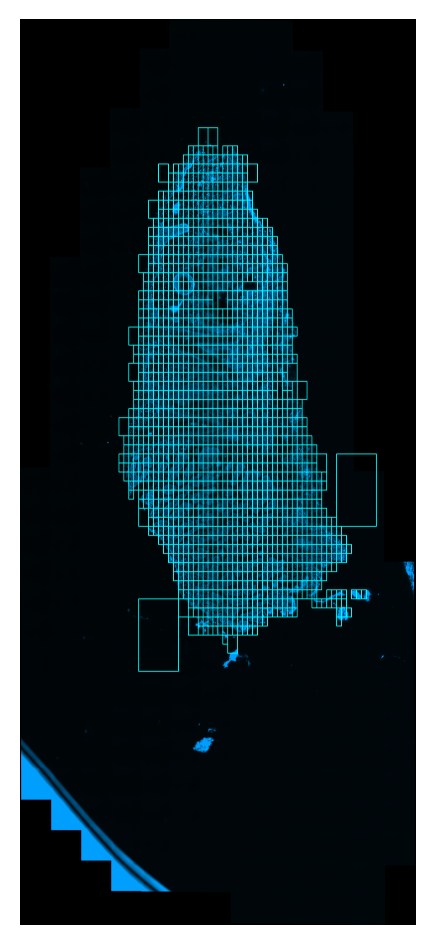

In [8]:
demo_image = draw_rectangles(img_dapi1, all_rects, thickness=15)
print(len(all_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(demo_image, vmax=255, vmin=0)
plt.axis('off')

In [10]:
all_collocalized_rects = list()

box_collocalized_scores = list()
child_count = dict()

for fn in list_output_files1:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            for index, parent_annot in enumerate(parent_annots):
                if child_count.get('_'.join(str(i) for i in parent_annot), None) is None:
                    
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, y_par, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if index == 0:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(big_window*img_dapi1.shape[1]),
                                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
                    elif index == 1:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(medium_window*img_dapi1.shape[1]),
                                    annot_y+int(medium_window*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects.append(par_rect)
                    child_count['_'.join(str(i) for i in parent_annot)] = 1
                    # if the is a child window inside the current bigger window, set the score of these boxes to 0 for nonovelapping results
                    box_collocalized_scores.append(0)

                else:
                    child_count['_'.join(str(i) for i in parent_annot)] += 1
                    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if len(parent_annots) == 1:
                        ratio = medium_window
                    elif len(parent_annots) == 2:
                        ratio = small_window
                    rect = [annot_x, 
                            annot_y, 
                            annot_x+int(ratio*img_dapi1.shape[1]),
                            annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects.append(rect)
                    score = collocalize_score(fn)

                    box_collocalized_scores.append(score)
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi1.shape[1]),
                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
            all_collocalized_rects.append(rect)

            box_collocalized_scores.append(0)


box_collocalized_scores = np.array(box_collocalized_scores)
heat_colors = np.array(map_heat_values2colors(box_collocalized_scores))

heat_colors = heat_colors * 255

heat_demo_image = draw_rectangles_heat(np.zeros_like(img_dapi1), all_collocalized_rects, heat_colors, box_collocalized_scores)



### Visualize heatmap of interaction between IL34 and CSF1R
1. Rotate heatmap 90 degree for better visualization

0.0 4.0


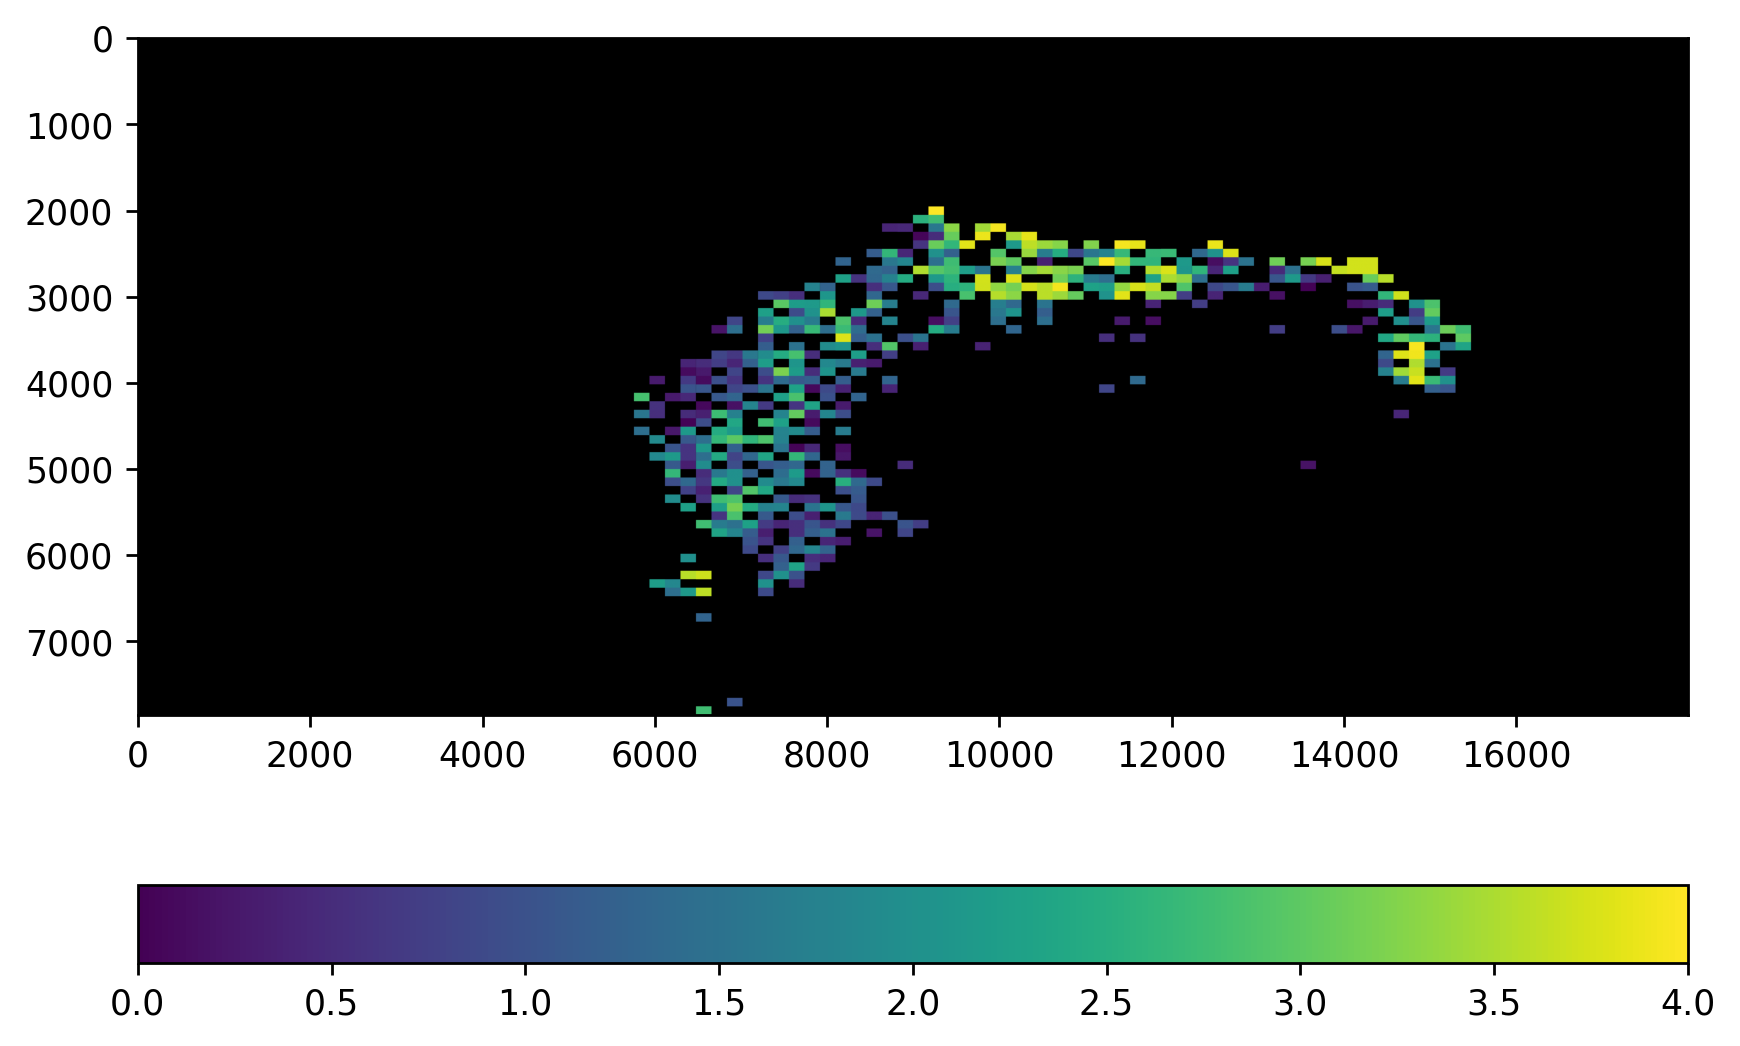

In [11]:
print(box_collocalized_scores.min(), box_collocalized_scores.max())
rotated_heat_demo_image = rotate(heat_demo_image, -90, resize=True)

plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(rotated_heat_demo_image, vmax=box_collocalized_scores.min(), vmin=box_collocalized_scores.max())
plt.colorbar(orientation='horizontal')

#### Remove the background from image and keep the tissue area only

1. Generate tissue mask using windows that detected nuclei  

In [22]:
# filter out the tissue fragment that torned apart from the tissue
all_rects.sort(key=x_element)
select_rects = all_rects[:-10]
select_rects.sort(key=y_element)
select_rects = select_rects[:-15]
select_rects.sort(key=xy_element)
select_rects = select_rects[:-5]

1595


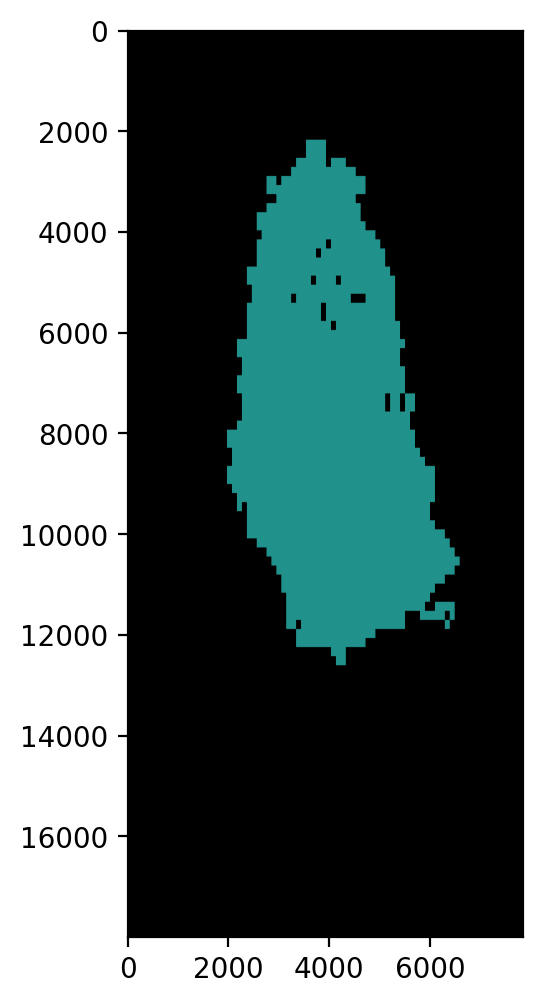

In [17]:
mask_dapi = np.zeros_like(img_dapi1)

box_collocalized_scores_2 = list()
for rect in select_rects:
    box_collocalized_scores_2.append(2)

mask_colors = np.array(map_heat_values2colors(box_collocalized_scores_2))
# print(heat_colors[10:25])
mask_colors = mask_colors * 255

mask_by_dapi = draw_rectangles_heat(mask_dapi, select_rects, mask_colors, box_collocalized_scores_2)
print(len(select_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(mask_by_dapi, vmax=255, vmin=0)

2. Plot the contours to cover the tissue area using the tissue mask

In [19]:
gray_all = cv2.cvtColor(mask_by_dapi, cv2.COLOR_RGB2GRAY)
contours = measure.find_contours(gray_all, 0.8)

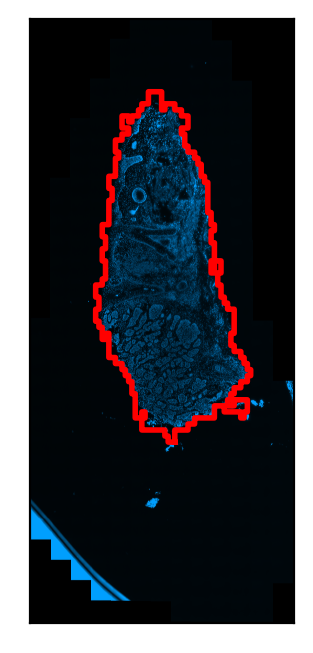

In [20]:
fig, ax = plt.subplots(dpi=200)
# ax.imshow(np.zeros_like(mask_by_dapi), cmap=plt.cm.gray)
ax.imshow(img_dapi1,cmap=plt.cm.gray)

for n, contour in enumerate(contours[0:1]):
    ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

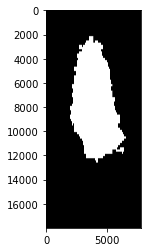

In [27]:
mask_binary = np.zeros_like(cv2.cvtColor(mask_by_dapi, cv2.COLOR_RGB2GRAY))
for n, contour in enumerate(contours[0:1]):
    mask_binary[np.round(contours[n][:, 0]).astype('int'), np.round(contours[n][:, 1]).astype('int')] = 1
fill_contour = ndi.binary_fill_holes(mask_binary)
fill_contour = fill_contour.astype('int')
plt.imshow(np.array(fill_contour), cmap='gray')

3. crop the background area from the image 

In [29]:
masked_all = cv2.bitwise_and(np.array(img_dapi1), np.array(img_dapi1), mask=np.array(fill_contour.astype('uint8')))
rotated_masked = rotate(masked_all, -90, resize=True)
mask = rgb2gray(rotated_masked) > 0
# thumbnail(Image.fromarray(np.array(rotated_masked.astype('uint8'))))
# Coordinates of non-black pixels.
coords = np.argwhere(mask)
# # Bounding box of non-black pixels.
x0, y0 = coords.min(axis=0)
x1, y1 = coords.max(axis=0) + 1  

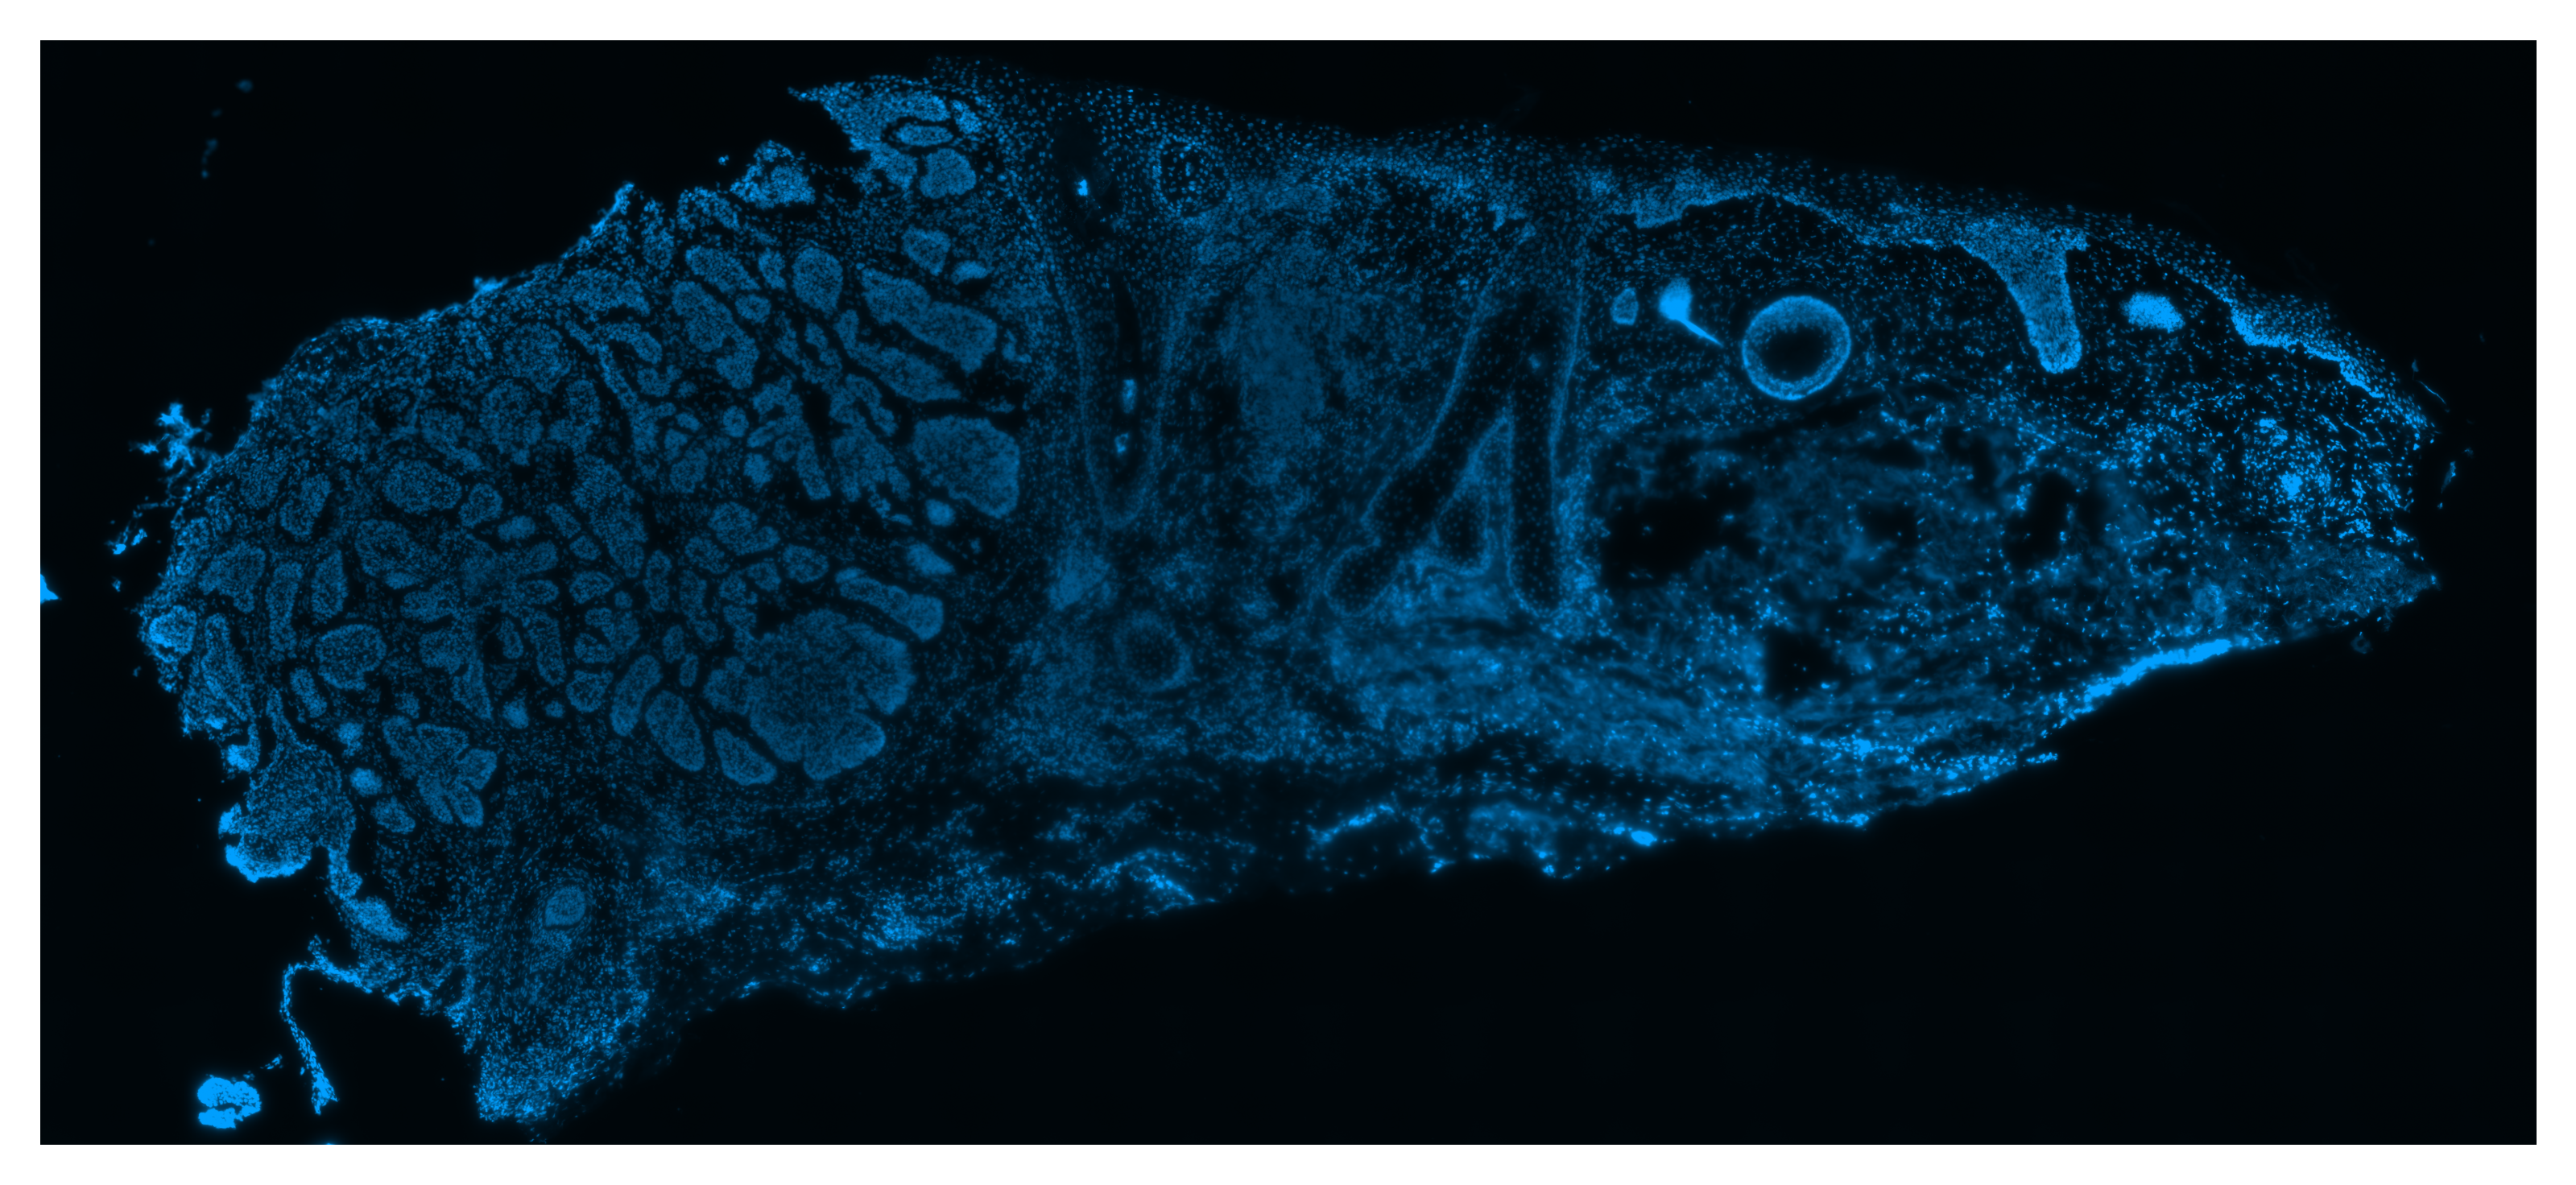

In [32]:
rotated_dapi1 = rotate( np.array(pil_img_dapi1), -90, resize=True)
plt.figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')
plt.imshow(rotated_dapi1)
# plt.colorbar()

plt.ylim(x0,x1)
plt.xlim(y0,y1)
plt.axis('off')

plt.gca().invert_yaxis()

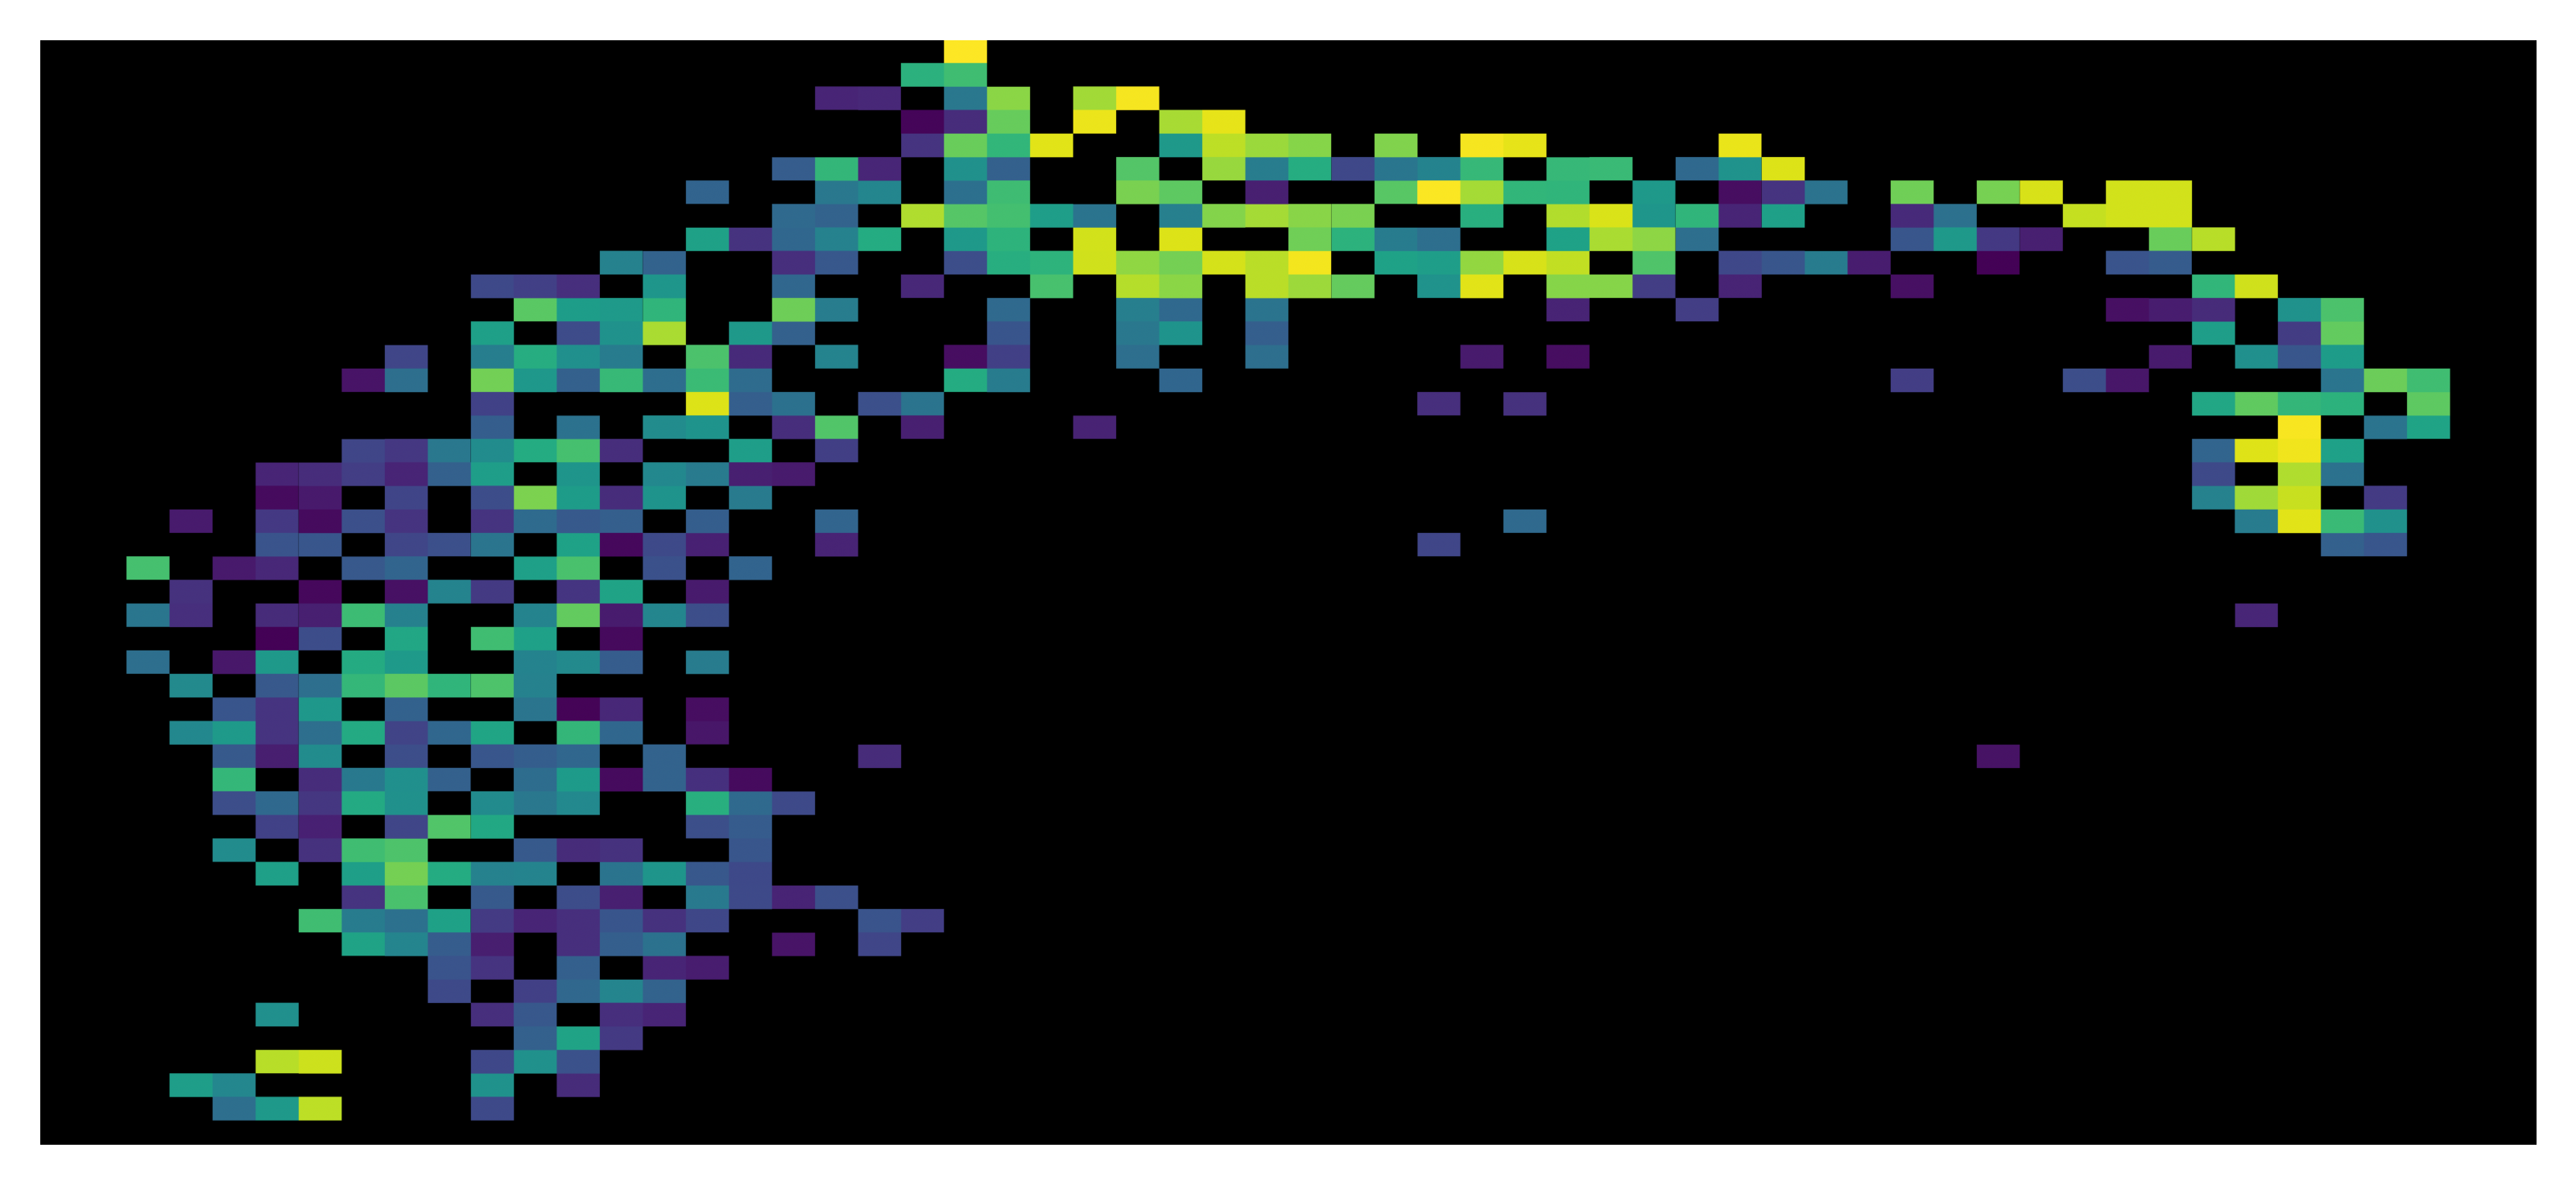

In [33]:
# rotated_heat_demo_image

plt.figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')
plt.imshow(rotated_heat_demo_image)
# plt.colorbar()

plt.ylim(x0,x1)
plt.xlim(y0,y1)
plt.axis('off')

plt.gca().invert_yaxis()

(5395.0, 15832.0, 6583.0, 1963.0)

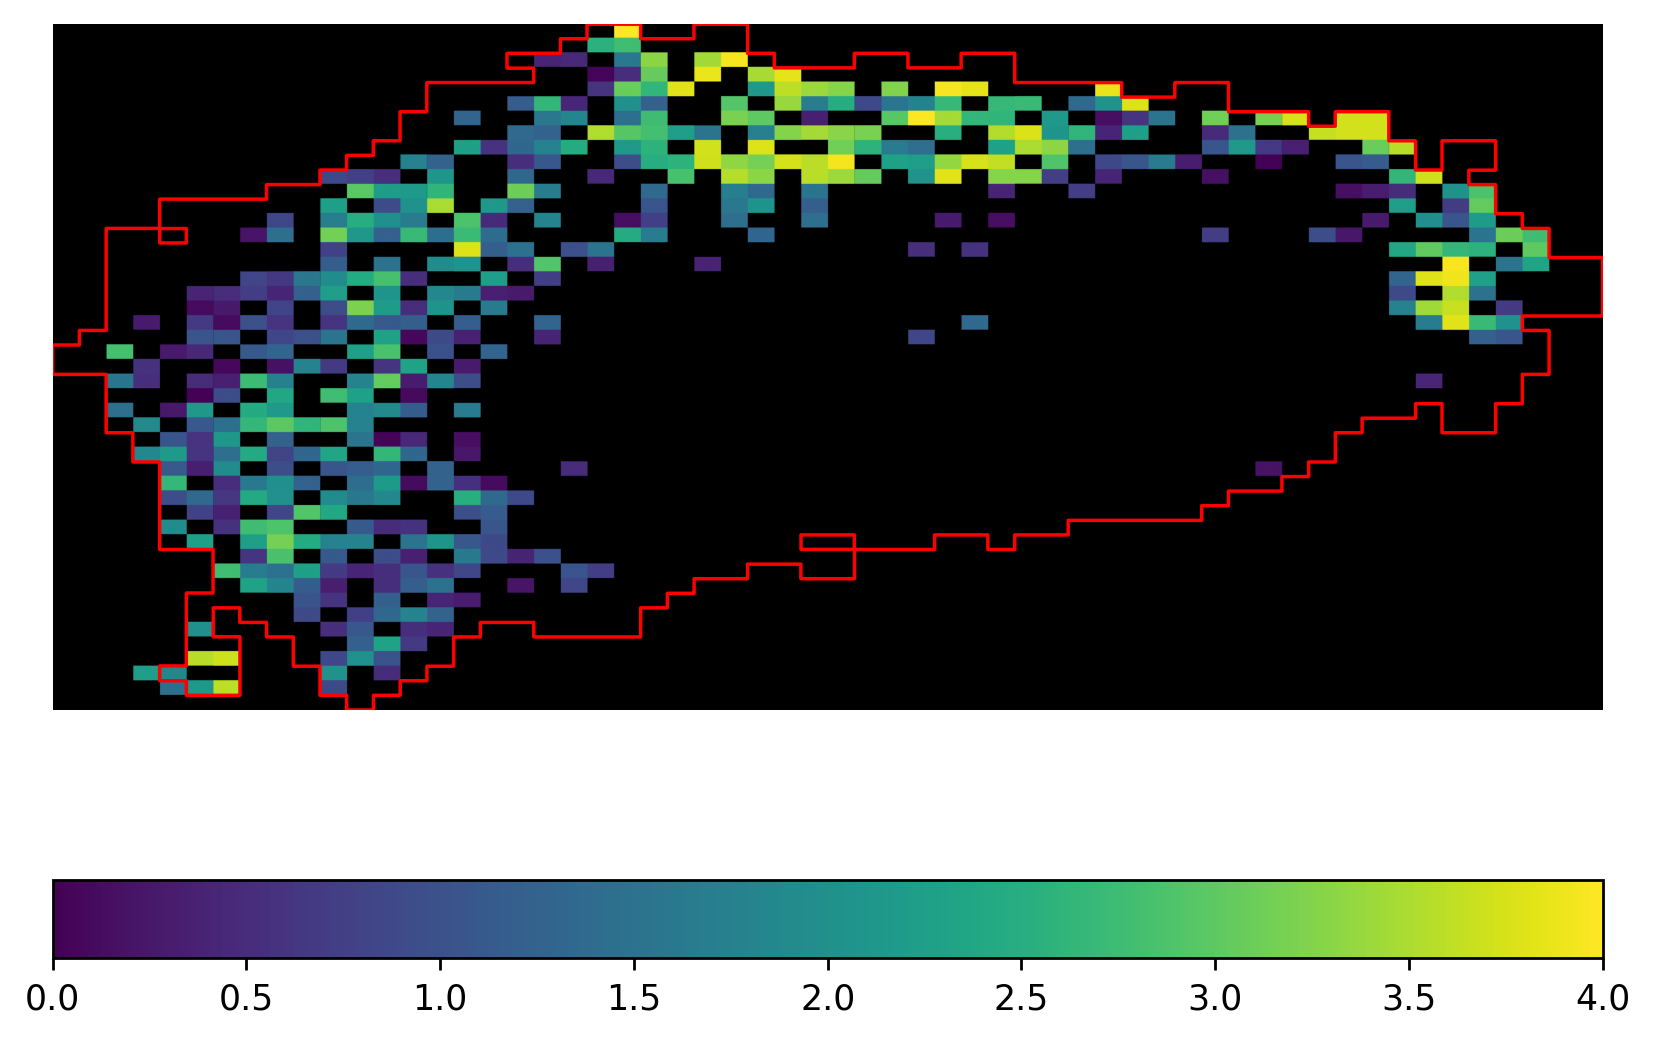

In [35]:
center_x, center_y, _ = heat_demo_image.shape
center = (center_x/2-0.5, center_y/2-0.5)
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
map_color = ax.imshow(rotated_heat_demo_image, vmin=box_collocalized_scores.min(), vmax=box_collocalized_scores.max())
for n, contour in enumerate(contours[0:1]):
    rotated_contour = rotate_contour(contour, -90, center)
    ax.plot(rotated_contour[:, 1], rotated_contour[:,0], 'r',linewidth=1)
fig.colorbar(map_color, orientation='horizontal')
plt.gca().invert_yaxis()
ax.set_ylim(x0,x1)
ax.set_xlim(y0,y1)
plt.gca().invert_yaxis()
plt.axis('off')

#### Visualize heatmap of interaction between THY1 and IGAM

4. Load detection result from second round image

In [37]:
scene1_output_dir2 = os.path.join(qupath_output, 'Scene_1_R2.3')
list_output_files_s2 = get_files_in_dir_recursively(scene1_output_dir2)
# extract the list of columns from one example file and create empty dataframe from this 
test_json = list_output_files_s2[1000]
df_json2 = convert_json2dataframe(test_json)
col_names = df_json2.columns

In [39]:
s1_cy7_coords = list()
# 'Centroid X', 'Centroid Y'
# Nucleus: DAPI mean
count_dot = 0
for fn in list_output_files_s2:
    if 'Cy7' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        count_dot += len(df_json)
        x_coords = df_json['Centroid X'].tolist()
        y_coords = df_json['Centroid Y'].tolist()
        coords = list(zip(x_coords, y_coords))
#         print(x_coords, y_coords, coords)        
        s1_cy7_coords.extend(coords)

print(len(s1_cy7_coords), count_dot)

2027 2027


5. Load the image registration modules to transform the coordinates of the detection results of ITGAM to other coordinate systems.

In [42]:
affine_transform = sitk.ReadTransform('BCC_Skin1_r1_registration_affine_transform.tfm')
bspline_transform = sitk.ReadTransform('BCC_Skin1_r2_registration_bspline_transform.tfm')

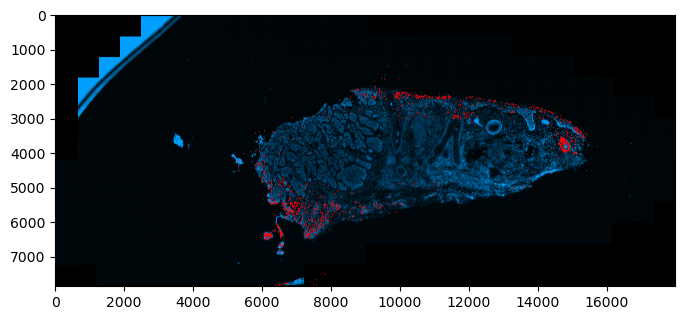

In [44]:
# visualize the coordinate of registered coordinates of cell positive with ITGAM in the first round image
s1_cy7_coords.sort(key=xy_element)
np_registered_r2_to_r1 = np.array(pil_img_dapi1)
clone_dapi1 = np_registered_r2_to_r1.copy()
transformed_cy7 = list()
for coord in s1_cy7_coords:
    x_coord, y_coord = coord
    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                               (img_dapi2.shape[0], img_dapi2.shape[1]), 
                                               original_czi1_size_s2)
    trans_coord_1, trans_state1 = inverse_transform_point(affine_transform, (annot_x, annot_y))
    trans_coord_2, trans_state2 = inverse_transform_point(bspline_transform, trans_coord_1)
    annot_x_transformed, annot_y_transformed = trans_coord_2
    transformed_cy7.append((int(annot_x_transformed), int(annot_y_transformed)))
    clone_dapi1 = cv2.circle(clone_dapi1, (int(annot_x_transformed), int(annot_y_transformed)), 15, (255,0,0), cv2.FILLED)
rotated_clone_dapi1 = rotate(clone_dapi1, -90, resize=True)
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(rotated_clone_dapi1)

In [51]:
def collocalize_score2(fn, count_cy7):
    equivalent_cy3_fn = substitute_file_name(fn, 'DAPI', 'Cy3')
    with open(fn) as json_file:
        dapi_json = json.load(json_file)
    cell_counts = len(dapi_json)
    if os.path.exists(equivalent_cy3_fn):
        try:
            with open(equivalent_cy3_fn) as json_file:
                cy3_json = json.load(json_file)
            present_cy3 = len(cy3_json)
        except:
            present_cy3 = 0
    if present_cy3 == 0 or count_cy7==0:
        return 0#, 0
    return (present_cy3+count_cy7)/cell_counts

In [53]:
assigned_boxes_cy7 = list()
all_collocalized_rects_s2 = list()
box_collocalized_scores_s2 = list()
child_count_s2 = dict()

for fn in list_output_files1:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            for index, parent_annot in enumerate(parent_annots):
                if child_count_s2.get('_'.join(str(i) for i in parent_annot), None) is None:
                    
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, y_par, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if index == 0:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(big_window*img_dapi1.shape[1]),
                                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
                    elif index == 1:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(medium_window*img_dapi1.shape[1]),
                                    annot_y+int(medium_window*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects_s2.append(par_rect)
                    child_count_s2['_'.join(str(i) for i in parent_annot)] = 1
                    box_collocalized_scores_s2.append(0)

                else:
                    child_count_s2['_'.join(str(i) for i in parent_annot)] += 1
                    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                               (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                               original_czi1_size)
                    if len(parent_annots) == 1:
                        ratio = medium_window
                    elif len(parent_annots) == 2:
                        ratio = small_window
                    rect = [annot_x, 
                            annot_y, 
                            annot_x+int(ratio*img_dapi1.shape[1]),
                            annot_y+int(ratio*img_dapi1.shape[0]*0.8)]
                    all_collocalized_rects_s2.append(rect)
                    count_trans_cy7 = 0
                    for coord in transformed_cy7:
#                         for coord in s1_cy3_coords[0:4000]:
                        if coord in assigned_boxes_cy7:
                            continue
                        else:
                            x_coord, y_coord = coord
                            if rect[0] < x_coord < rect[2] and rect[1] < y_coord < rect[3]:
                                assigned_boxes_cy7.append(coord)
                                count_trans_cy7 += 1
                    score = collocalize_score2(fn, count_trans_cy7)
#                     if score > 4:
#                         print(score, rect)
                    box_collocalized_scores_s2.append(score)
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                       (img_dapi1.shape[0], img_dapi1.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi1.shape[1]),
                    annot_y+int(big_window*img_dapi1.shape[0]*0.8)]
            all_collocalized_rects_s2.append(rect)

            box_collocalized_scores_s2.append(0)


box_collocalized_scores_s2 = np.array(box_collocalized_scores_s2)

heat_colors2 = np.array(map_heat_values2colors(box_collocalized_scores_s2))

heat_colors2 = heat_colors2 * 255

print(len(all_collocalized_rects_s2))
heat_demo_image_s2 = draw_rectangles_heat(np.zeros_like(img_dapi1), all_collocalized_rects_s2,
                                       heat_colors2, box_collocalized_scores_s2)


3230


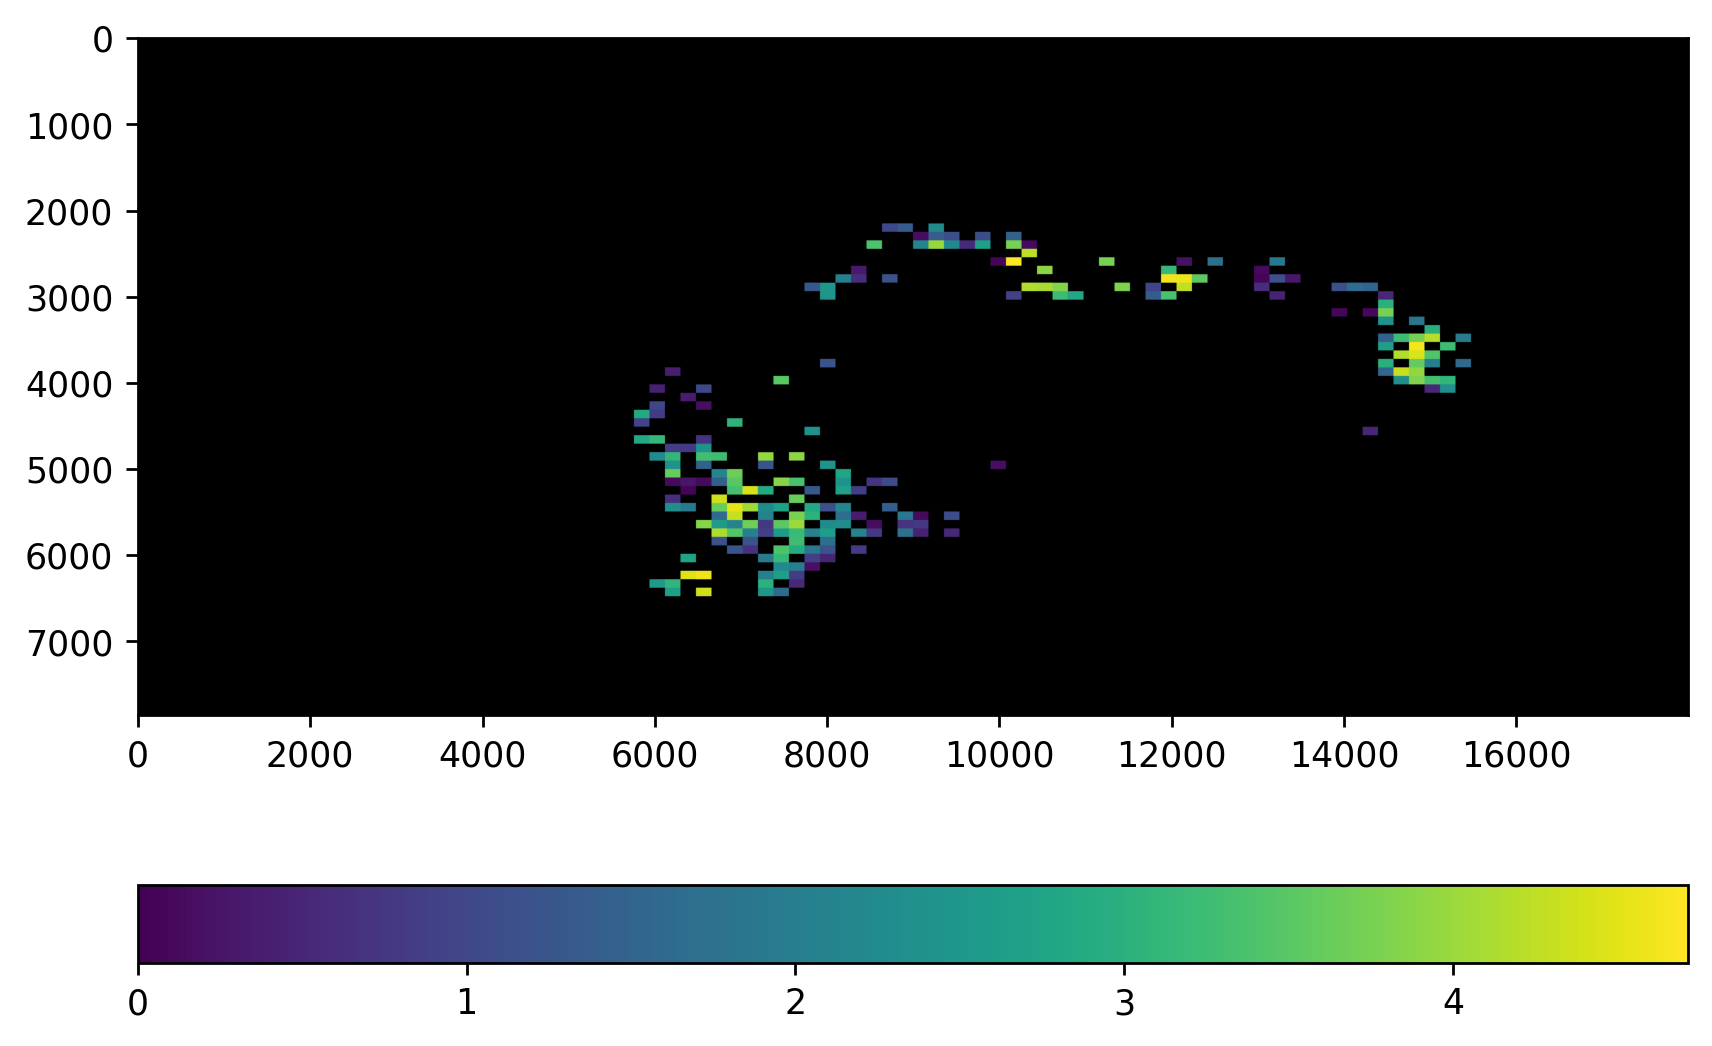

In [57]:
rotated_heat_demo_image_s12 = rotate(heat_demo_image_s2, -90, resize=True)

plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(rotated_heat_demo_image_s12, vmax=box_collocalized_scores_s2.max(), vmin=box_collocalized_scores_s2.min())
plt.colorbar(orientation='horizontal')

6. Outline the tissue boundary into the heatmap

(5395.0, 15832.0, 6583.0, 1963.0)

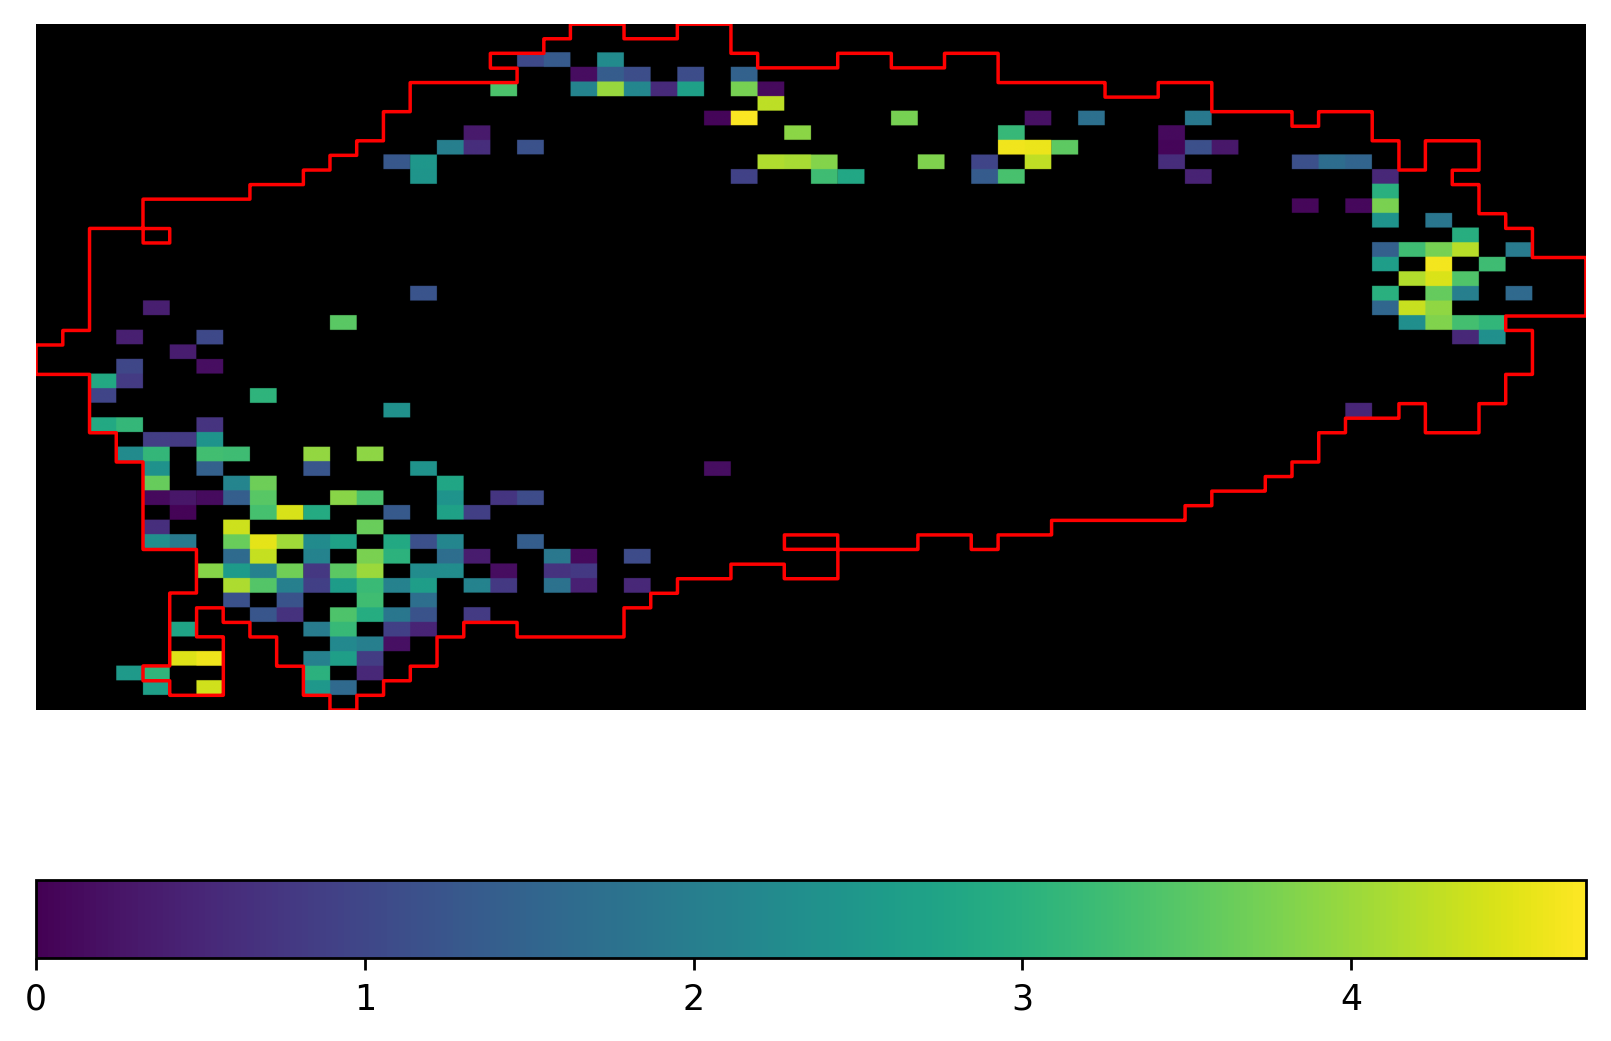

In [58]:
rotated_heat_demo_image = rotate(heat_demo_image_s2, -90, resize=True)
center_x, center_y, _ = heat_demo_image_s2.shape
center = (center_x/2-0.5, center_y/2-0.5)
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')

map_color = ax.imshow(rotated_heat_demo_image, vmin=box_collocalized_scores_s2.min(), vmax=box_collocalized_scores_s2.max())
for n, contour in enumerate(contours[0:1]):
    rotated_contour = rotate_contour(contour, -90, center)
    ax.plot(rotated_contour[:, 1], rotated_contour[:,0], 'r',linewidth=1)
fig.colorbar(map_color, orientation='horizontal')
plt.gca().invert_yaxis()
ax.set_ylim(x0,x1)
ax.set_xlim(y0,y1)
plt.gca().invert_yaxis()
plt.axis('off')